In [8]:
%%bash --bg
#create several player processes. Each process plays games and saves results
#the loop below spawns 10 players. If you are doing this on a laptop, reducing to 2-4 is okay
for i in `seq 1 20`; 
do
        THEANO_FLAGS=device=cpu,floatX=float32 python tinyverse neonrace.py play -b 1 &
        sleep(20)
done  

Starting job # 2 in a separate thread.


In [9]:
import time
from tinyverse.database import Database
db = Database()
while db.redis.llen("sessions") < 2500:
    time.sleep(5)
    print(db.redis.llen("sessions"),'sessions',end=',')

2010 sessions,2010 sessions,2010 sessions,2011 sessions,2012 sessions,2013 sessions,2015 sessions,2017 sessions,2019 sessions,

KeyboardInterrupt: 

In [ ]:
%%bash --bg
#create learner process on GPU. batch size 10
THEANO_FLAGS=device=gpu,floatX=float32 python tinyverse neonrace.py train -b 10 &

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import theano
import theano.tensor as T
import pickle
import neonrace
from tinyverse.database import Database
from agentnet.environment.session_batch import SessionBatchEnvironment


db = Database()
self=experiment=neonrace.make_experiment(db)
agent = self.agent


observation_shape=(1, 64, 64)  # same as env.observation_space.shape
sequence_length=25  # how many steps to make before updating weights

#make replay environment
observations = T.tensor(theano.config.floatX,broadcastable=(False,)*(2+len(observation_shape)),
                        name="observations[b,t,color,width,height]")
actions = T.imatrix("actions[b,t]")
rewards,is_alive = T.matrices("rewards[b,t]","is_alive[b,t]")
prev_memory = [l.input_var for l in agent.agent_states.values()]



replay = SessionBatchEnvironment(observations,
                                 [observation_shape],
                                 actions=actions,
                                 rewards=rewards,
                                 is_alive=is_alive,
                                 preceding_agent_memories=prev_memory
                                )

#replay sessions
_, _, h_seq, _, (logits_seq, V_seq) = agent.get_sessions(
    replay,
    session_length=sequence_length,
    experience_replay=True,
    unroll_scan=False,#speeds up compilation my 10x, slows down training by 20% (still faster than TF :P )
)
rng_updates = agent.get_automatic_updates()

# compute pi(a|s) and log(pi(a|s)) manually [use logsoftmax]
# we can't guarantee that theano optimizes logsoftmax automatically since it's still in dev
logits_flat = logits_seq.reshape([-1,logits_seq.shape[-1]])
policy_seq = T.nnet.softmax(logits_flat).reshape(logits_seq.shape)
logpolicy_seq = T.nnet.logsoftmax(logits_flat).reshape(logits_seq.shape)

#####################
import lasagne
from agentnet.learning import a2c
# get policy gradient
elwise_actor_loss,elwise_critic_loss = a2c.get_elementwise_objective(policy=logpolicy_seq,
                                                                     treat_policy_as_logpolicy=True,
                                                                     state_values=V_seq[:,:,0],
                                                                     actions=replay.actions[0],
                                                                     rewards=replay.rewards,
                                                                     is_alive=replay.is_alive,
                                                                     gamma_or_gammas=0.99,
                                                                     n_steps=None,
                                                                     n_steps_advantage=1,
                                                                     return_separate=True)


reg_entropy = 1e-2*T.mean(T.sum(policy_seq*logpolicy_seq,axis=-1))
loss = elwise_actor_loss.mean() + 0.25*elwise_critic_loss.mean() + reg_entropy


# Compute weight updates
dV,dl = T.grad(-loss,[V_seq,logits_seq])
#####################



# compile train function
inputs = [observations, actions, rewards, is_alive]+prev_memory
eval_fun = theano.function(inputs, 
                           [policy_seq, V_seq,dV,logits_seq,dl],
                           updates=rng_updates,on_unused_input='ignore')



/home/hedgedir/agentnet/agentnet/agent/recurrence.py:595: UserWarning: Warning: recurrent loop without unroll_scan got nonempty random state updates list. That happened because there is some source of randomness (e.g. dropout) inside recurrent step graph. To compile such graph, one must either call .get_automatic_updates() right after .get_output and pass these updates to a function, or use no_defalt_updates=True when compiling theano.function.
  warn("Warning: recurrent loop without unroll_scan got nonempty random state updates list. That happened"
WARNING (theano.tensor.blas): We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
[2017-01-17 19:13:50,386] We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


In [2]:
avg_reward_per_session = []
print(db.redis.llen("sessions"))

2005


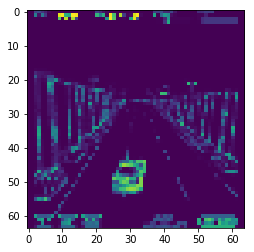

In [3]:
plt.imshow(db.get_session(0)[0][0,0])

n_sessions: 2139


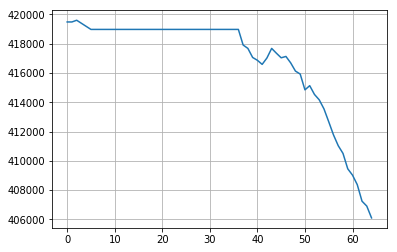

r	V		Ent	Logits
+0.0 +0.377 (-0.538) +0.799 | +0.66(-1.67) -3.21(+0.00) -1.21(+0.01) +3.90(+1.25) -1.62(+0.01) +2.67(+0.37) -0.74(+0.01) -0.08(+0.03)
+0.0 -0.055 (+0.328) +0.784 | +1.77(+0.03) -1.94(-1.20) -4.90(+0.00) +5.03(+0.77) -0.79(+0.00) +4.29(+0.38) -1.08(+0.00) +0.04(+0.01)
+0.0 -0.358 (+0.936) +0.905 | +0.85(+0.09) -2.21(+0.00) -2.36(+0.00) +3.69(+1.48) -0.95(-2.17) +2.64(+0.53) -0.37(+0.03) -0.06(+0.04)
+0.0 -0.914 (+2.050) +1.003 | +0.12(-0.16) -3.69(+0.00) +0.26(+0.01) +3.40(+0.08) -2.39(+0.00) +3.09(+0.06) -0.33(+0.00) -0.11(+0.00)
+0.0 -0.966 (+2.156) +0.654 | +1.12(-0.47) -1.01(+0.00) -3.35(+0.00) +4.57(+0.37) -1.02(+0.00) +2.96(+0.08) -1.11(+0.00) -0.09(+0.00)
+0.0 -1.098 (+2.423) +0.623 | +0.10(-0.01) -0.74(-0.00) -3.29(+1.30) +4.75(-1.03) -0.80(-0.00) +3.33(-0.24) -1.32(-0.00) -0.11(-0.01)
+0.0 -0.782 (+1.793) +0.889 | +0.90(+0.06) -0.59(-1.44) -4.66(+0.00) +3.92(+1.05) +0.66(+0.04) +2.44(+0.25) -0.50(+0.01) -0.03(+0.02)
+0.0 -1.156 (+2.544) +0.541 | +0.34(-0.00) -0.

In [ ]:
#MEGA-controller of doom. Draws all the stuff i wanted to see for some reason. Don't try to analize
from IPython.display import clear_output
while True:
    if db.redis.exists("weights"):
        weights = db.loads(db.redis.get('weights'))
        if any(map(np.any,map(np.isnan,weights))):
            print("Weights broken!!!")
    
    print("n_sessions:",db.redis.llen("sessions"))
    plt.plot(avg_reward_per_session)
    plt.grid()
    plt.show()
    
    
    from scipy.stats import entropy
    db.load_all_params(experiment.agent,errors='raise')
    s,a,r,alive,mem = db.loads(db.redis.lindex('sessions',np.random.randint(1000)))

    pi,v,dv,logits,dlogits = eval_fun([s],[a],[r],[alive],*[m[None] for m in mem])
    
    print ("r\tV\t\tEnt\tLogits")
    for lo_i,dlo_i,pi_i,v_i,dv_i,r_i in zip(
        logits.reshape(-1,8),
        dlogits.reshape(-1,8),
        pi.reshape(-1,8),
        v.reshape(-1),
        dv.reshape(-1),
        r.reshape(-1)):
        logit_str = map(lambda l,dl:("%+.2f(%+.2f)"%(l,100*dl)),lo_i,dlo_i)
        print ("%+.1f"%r_i, "%+.3f"%v_i,"(%+.3f)"%(100*dv_i),"%+.3f"%entropy(pi_i),"|"," ".join(logit_str))
    

    R=0
    n_iter = min(5000,db.num_sessions())
    for i in range(n_iter)[::-1]:
        s,a,r,d,m = db.loads(db.redis.lindex('sessions',i))
        R += sum(r)
    R *= 5000./n_iter
    avg_reward_per_session.append(R)
    clear_output(True)
    

In [2]:
!kill -9 $(ps aux | grep tinyverse | awk '{print $2}') #uncomment to hard kill all
from tinyverse.database import Database
db = Database()
for key in db.redis.keys():
    db.redis.delete(key)